In [1]:
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_rows', 1500)

#models an pre-processing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from src.data_functions import wrangle
w = wrangle()
import statsmodels.api as sm

#metrics
from sklearn.metrics import auc, f1_score, recall_score, roc_curve, precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from src.model_functions import thresh_selection, odds_to_prob

#model saving
import pickle

In [2]:
data = pd.read_csv('data/model/new_model_data.csv')
len(data)

3193

In [9]:
def remove_new_patients(df, threshold=2000):
    #new patients defined as Tenure < 400 and Recency < 400
    new_patients_nums = df[(df['Tenure'] < 400)&(data['Recency'] < 400)]['PatNum']
    new_df = df[~df['PatNum'].isin(new_patients_nums)]
    print(f'Total number of new patients: {len(new_patients_nums)}\nTotal Count in new Dataset: {len(new_df)}')
    new_df = new_df[new_df["Recency"] < threshold]
    return new_df

In [11]:
fresh = remove_new_patients(data)

Total number of new patients: 75
Total Count in new Dataset: 3118


In [13]:
#Sanity check for target distribution in the dataset 
data['churn'] = np.where(data['Recency'] >= 400, 1, 0)
fresh['churn'] = np.where(fresh['Recency'] >= 400, 1, 0)
data['churn'].value_counts()/len(data) * 100
fresh['churn'].value_counts()/len(fresh) * 100

1    71.093016
0    28.906984
Name: churn, dtype: float64

0    52.900811
1    47.099189
Name: churn, dtype: float64

### Churn Distribution Plot

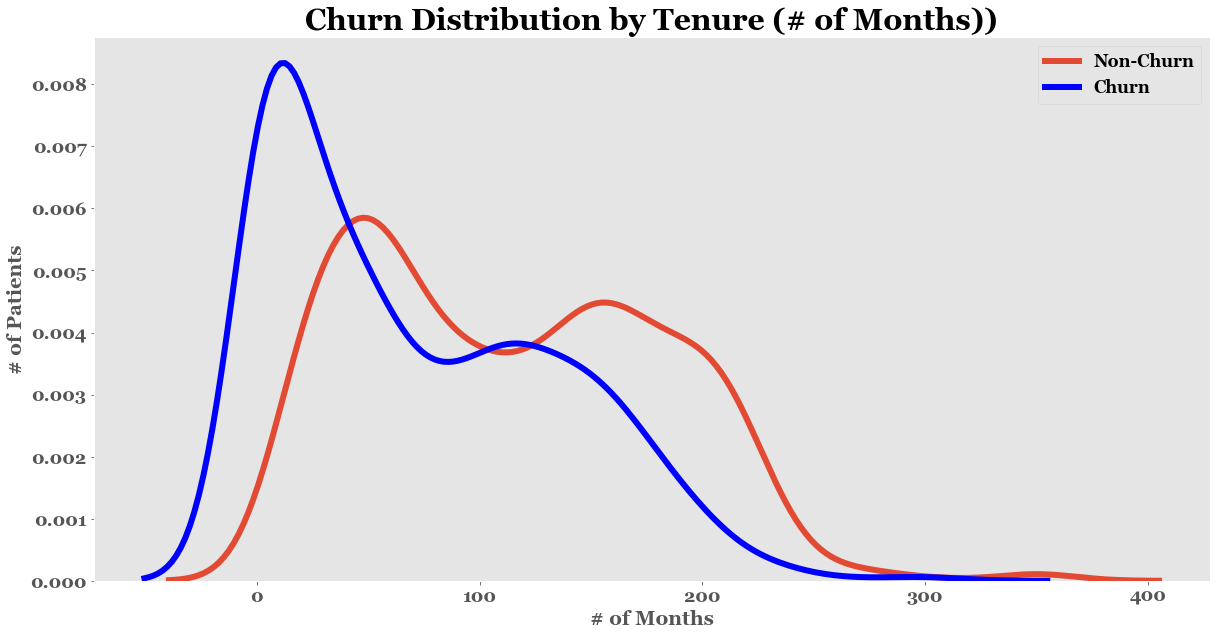

In [14]:
def plot_churn(df):
    plt.style.use('ggplot')
    #tenure_non_churn = df[df['churn'] == 0]['Tenure']/30
    #tenure_churn = df[df['churn'] == 1]['Tenure']/30
    sns.kdeplot(x=df[df['churn'] == 0]['Tenure']/30, lw=6, label='Non-Churn')
    sns.kdeplot(x=df[df['churn'] == 1]['Tenure']/30, lw=6, label='Churn', color='blue')
    #hist_churn = plt.hist(tenure_churn, bins=30, edgecolor='black', lw=2, color='blue', label='Churn')
    #hist_non_churn = plt.hist(tenure_non_churn, bins=30, edgecolor='black', lw=1.5,color='red', alpha=0.4, label='Non-churn')
    leg = plt.legend(fontsize='xx-large')
    title = plt.title('Churn Distribution by Tenure (# of Months))', fontweight='bold', fontsize=30)
    xlabel = plt.xlabel('# of Months', fontweight='bold', fontsize=20)
    ylabel = plt.ylabel('# of Patients', fontweight='bold', fontsize=20)
    xticks = plt.xticks(fontsize=18, fontweight='bold')
    yticks = plt.yticks(fontsize=18, fontweight='bold')
    plt.grid(False)
plot_churn(fresh)

### Extract Label from data and Scale

In [320]:
drop_cols = ['PatNum', 'Recency', 'churn']

def extract(df, drop_cols):
    X = df.drop(drop_cols, axis=1)
    y = df.churn
    return X, y

def scale_data(data):
    scaler = StandardScaler()
    Xscaled = scaler.fit_transform(data)
    return Xscaled

X, y = extract(fresh, drop_cols)
X.shape, y.shape

((1603, 14), (1603,))

In [321]:
Xscaled = scale_data(X)
Xscaled.shape

(1603, 14)

### Create Train/Test split

In [322]:
xtrain, xtest, ytrain, ytest = train_test_split(Xscaled, y, test_size = 0.25)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((1202, 14), (401, 14), (1202,), (401,))

### Instantiate Model and Train

In [328]:
lr = LogisticRegressionCV(solver='liblinear', penalty='l1', max_iter=500, cv=10, scoring='recall')

In [329]:
start = datetime.now()
lr.fit(xtrain, ytrain)
total = datetime.now() - start
print(f'{total/60} minutes of run time.')

LogisticRegressionCV(cv=10, max_iter=500, penalty='l1', scoring='recall',
                     solver='liblinear')

0:00:00.003474 minutes of run time.


In [331]:
lr.score(xtrain, ytrain)
lr.score(xtest, ytest)

0.7920962199312714

0.815028901734104

In [332]:
predictions = lr.predict(xtest)
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       228
           1       0.81      0.82      0.81       173

    accuracy                           0.84       401
   macro avg       0.83      0.84      0.83       401
weighted avg       0.84      0.84      0.84       401



In [251]:
def priority_list(original_df, predicted_probas, thresh):
    df = pd.DataFrame(predicted_probas).sort_values(1, ascending=False)
    inds = df[df[1] >= thresh].index
    patients = original_df.loc[inds, :].loc[:, ['PatNum', 'tenure', 'num_visits', 'LastVisit']]
    #patients = patients.sort_values(['LastVisit', 'tenure', 'num_visits'], ascending=[False, False, False])
    return patients


In [333]:
threshold = 0.48
predicted_proba = lr.predict_proba(xtest)
predicted = (predicted_proba [:,1] >= threshold).astype('int')
print(classification_report(ytest, predicted))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       228
           1       0.80      0.84      0.82       173

    accuracy                           0.84       401
   macro avg       0.84      0.84      0.84       401
weighted avg       0.84      0.84      0.84       401



In [334]:
confusion_matrix(ytest, predictions)

array([[195,  33],
       [ 32, 141]])

F1 Score at 0.2 prediction threshold: 0.76
False Positives = 95, False Negatives = 9


F1 Score at 0.22 prediction threshold: 0.76
False Positives = 89, False Negatives = 12


F1 Score at 0.24 prediction threshold: 0.77
False Positives = 84, False Negatives = 13


F1 Score at 0.26 prediction threshold: 0.78
False Positives = 77, False Negatives = 13


F1 Score at 0.28 prediction threshold: 0.79
False Positives = 69, False Negatives = 14


F1 Score at 0.3 prediction threshold: 0.8
False Positives = 63, False Negatives = 16


F1 Score at 0.32 prediction threshold: 0.81
False Positives = 60, False Negatives = 16


F1 Score at 0.34 prediction threshold: 0.8
False Positives = 57, False Negatives = 19


F1 Score at 0.36 prediction threshold: 0.8
False Positives = 54, False Negatives = 21


F1 Score at 0.38 prediction threshold: 0.8
False Positives = 51, False Negatives = 23


F1 Score at 0.4 prediction threshold: 0.8
False Positives = 49, False Negatives = 25


F1 Score at 0.42 prediction th

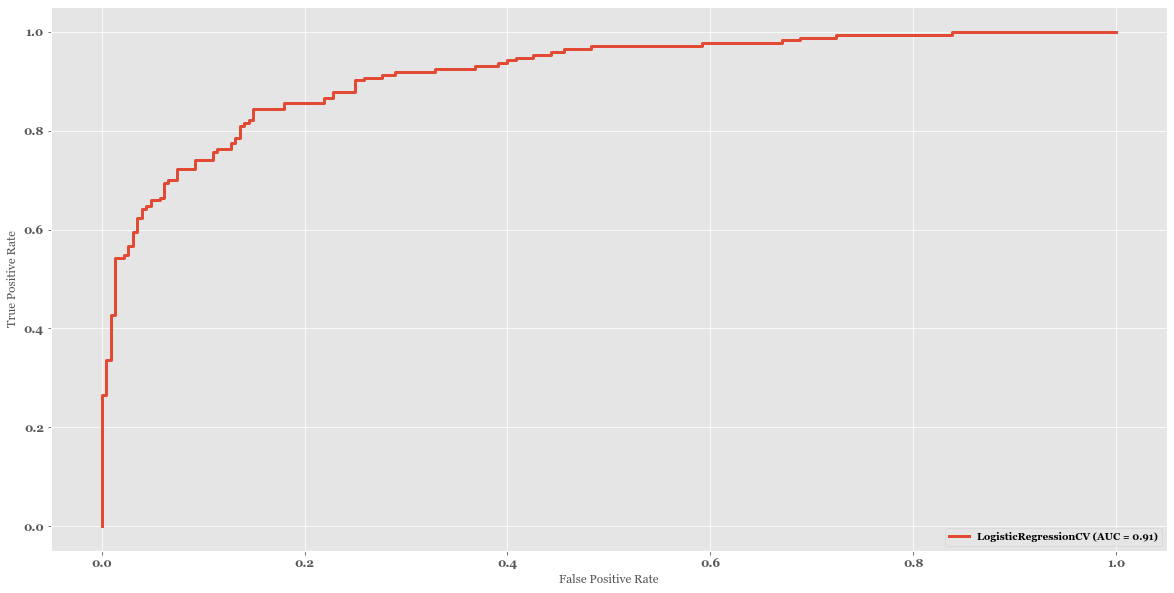

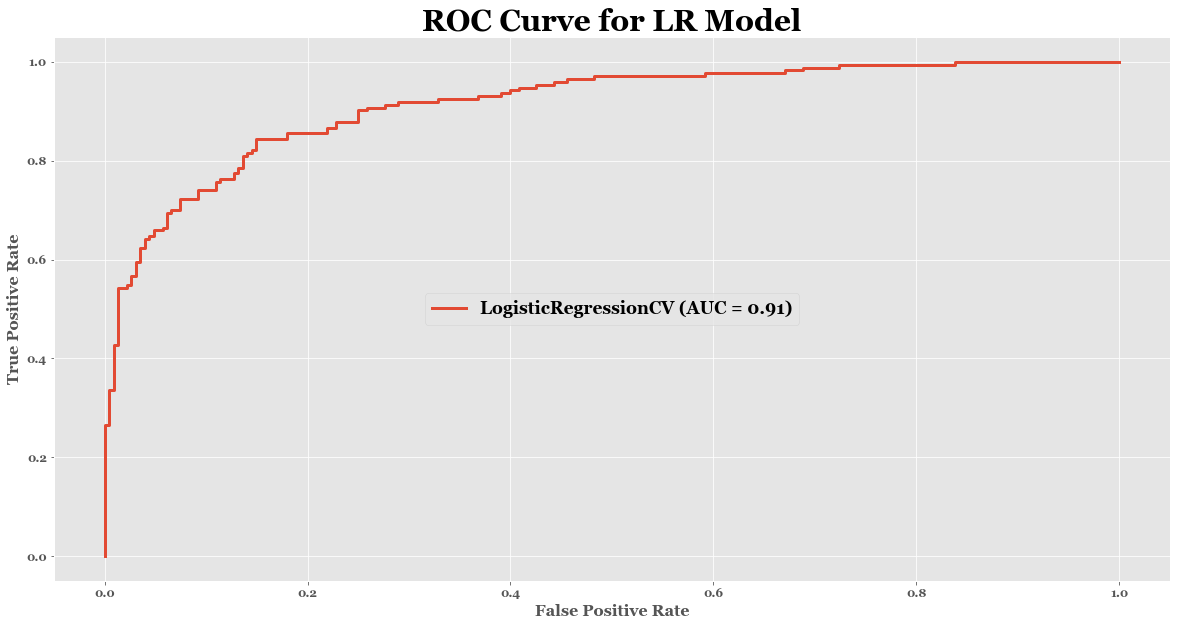

In [335]:
thresh_selection(xtest, ytest, lr, 0.2, 0.57, 0.02)
curve = plot_roc_curve(lr, xtest, ytest, lw=3)
title = plt.title('ROC Curve for LR Model', fontweight='bold', fontsize=30)
ylabel = plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
xlabel = plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
leg = plt.legend(fontsize='xx-large', loc=10)

### Save Model for Deployment

In [342]:
pickle_filename = "src/bestLRmodel.pkl"  

with open(pickle_filename, 'wb') as file:  
    pickle.dump(lr, file)

In [343]:
churns = lr.predict_proba(xtest)[:,1]
nonchurns = lr.predict_proba(xtest)[:,0]

### Logistic Regression with statsmodel

In [344]:
log_reg = sm.Logit(ytrain, xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.390556
         Iterations 8


In [345]:
print(log_reg.summary(xname=X.columns.tolist()))

                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 1202
Model:                          Logit   Df Residuals:                     1188
Method:                           MLE   Df Model:                           13
Date:                Mon, 11 Jan 2021   Pseudo R-squ.:                  0.4361
Time:                        21:10:22   Log-Likelihood:                -469.45
converged:                       True   LL-Null:                       -832.56
Covariance Type:            nonrobust   LLR p-value:                8.494e-147
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Gender        -0.0585      0.083     -0.705      0.481      -0.221       0.104
EstBalance     0.1374      0.124      1.105      0.269      -0.106       0.381
InsEst        -1.1963      0.299     -4.005      0.0

### Calculating Odds and Probas from Coefficients

In [352]:
def create_odds_table(df, model):
    coefs = pd.DataFrame().from_dict(dict(zip(df.columns, model.coef_[0])), orient='index').sort_values(by=0)
    coefs.rename(columns={0:'Log Odds'}, inplace=True)
    coefs['Odds'] = np.exp(coefs['Log Odds'])
    coefs['Probability'] = coefs['Log Odds'].apply(odds_to_prob)
    return coefs

In [353]:
create_odds_table(X, lr)

,Log Odds,Odds,Probability
InsEst,-1.365870,0.255159,0.203288
seen_by_10,-1.245203,0.287882,0.223532
Tenure,-0.858487,0.423803,0.297655
seen_by_15,-0.785002,0.456119,0.313243
seen_by_7,-0.359921,0.697732,0.410979
HasIns,-0.107211,0.898336,0.473223
seen_by_1,-0.072861,0.929730,0.481793
Gender,-0.034560,0.966030,0.491361
Total,0.046050,1.047126,0.511510
Frequency,0.091577,1.095901,0.522878
